In [6]:
from util import * 
import matplotlib.pyplot as plt 

Corrcoef: 0.9324


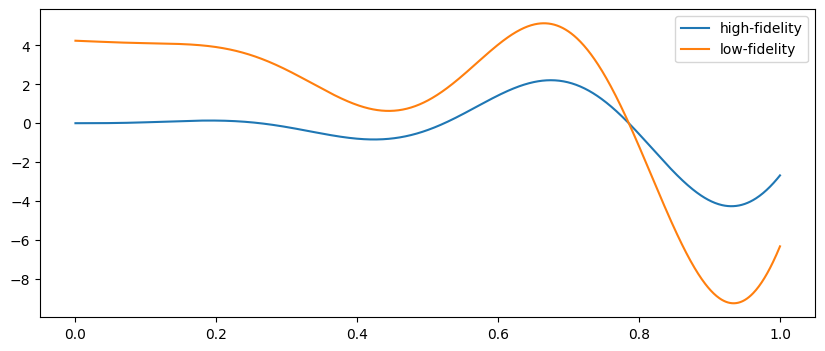

In [182]:
# # LINEAR-B 
funcs = [
    lambda x: ((5*x**2) * np.sin(12*x)), 
    lambda x: (2*(5*x**2) * np.sin(12*x)+(x**3-0.5*np.sin(3*x-0.5))+4*np.cos(2*x))]

# Assigning sample sizes
N_hi, N_lo, N_test = 5, 50, 1000 
# Assigning computational budgets 
C_hi, C_lo = 5, 1 
X_hi = np.random.uniform(0,1.0, N_hi)
X_lo = np.random.uniform(0,1.0, N_lo)
X_test = np.linspace(0,1.0, N_test)

# Defining data_dict 
data_dict = {
    0:{
        'X':X_hi.reshape(-1,1), 
        'Y':funcs[0](X_hi), 
        'noise_var':1e-7
    }, 
    1:{
        'X':X_lo.reshape(-1,1),
        'Y':funcs[1](X_lo),
        'noise_var':1e-7
    }
}

corr_coef = np.corrcoef(funcs[0](X_test), funcs[1](X_test))[0,1]

print("Corrcoef: %.4f" % corr_coef)

plt.figure(figsize=(10,4))
plt.plot(X_test, funcs[0](X_test), label = "high-fidelity")
plt.plot(X_test, funcs[1](X_test), label = "low-fidelity")
plt.legend()

In [135]:
g1 = GP(
    X_lo.reshape(-1,1),
    funcs[1](X_lo), 
    RBF, 
    Linear, 
    max_cond = 1e4,
    noise_var = 1e-7, 
    epsilon = 1e-7
)

g1.set_params(
    {'noise_var': jnp.array(-11.44789151), 
     'k_param':   jnp.array([45.18417054, -2.55169638]),
     'm_param':   jnp.array([1.31050888, 6.8476559 ])}
)

Calibrated white noise variance: 1.0045e-01


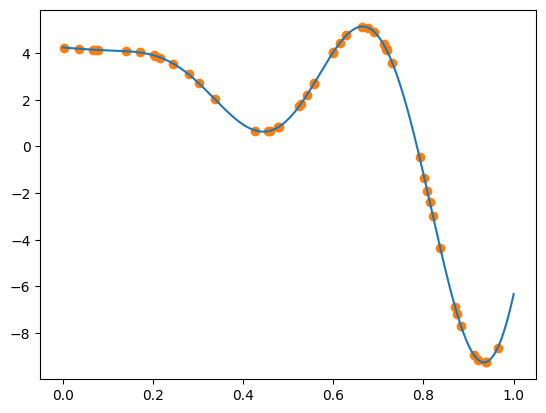

In [128]:
mean, var = g1.predict(X_test.reshape(-1,1), full_cov = False)
conf = 2 * np.sqrt(var)

plt.plot(X_test, funcs[1](X_test), label = "low-fidelity")
plt.fill_between(X_test, mean - conf, mean + conf, alpha = 0.5)
plt.scatter(X_lo, funcs[1](X_lo))

In [136]:
g0 = DeltaGP(
    X_hi.reshape(-1,1),
    funcs[0](X_hi), 
    funcs[1](X_hi), 
    RBF, 
    Linear, 
    noise_var = 1e-8, 
    epsilon = 1e-8, 
    max_cond = 1e6
)

g0.set_params(
    {'noise_var': jnp.array(-11.44789151), 
     'k_param': jnp.array([2.09575508, 1.13479578]),
     'm_param': jnp.array([-0.27237311, -0.41059883]),
     'rho': jnp.array(0.49971902)}
)

Calibrated white noise variance: 7.4818e-05


In [137]:
kr = GP(
    X_hi.reshape(-1,1),
    funcs[0](X_hi), 
    RBF, 
    Linear, 
    noise_var = 1e-8, 
    epsilon = 1e-8, 
    max_cond = 1e8
)
kr.set_params(
    {'noise_var':jnp.array(-13.46455067),
    'k_param':   jnp.array([ 8.77047402, -2.59487462]),
    'm_param':   jnp.array([-1.13692191,  5.07544546])}
) 
# optimizer = ADAM(kr, neg_mll, beta1 = 0.9, beta2 = 0.999)
# optimizer.run(lr = 1e-3, epochs = 25000, params = ['k_param', 'm_param'])

Calibrated white noise variance: 1.0000e-08


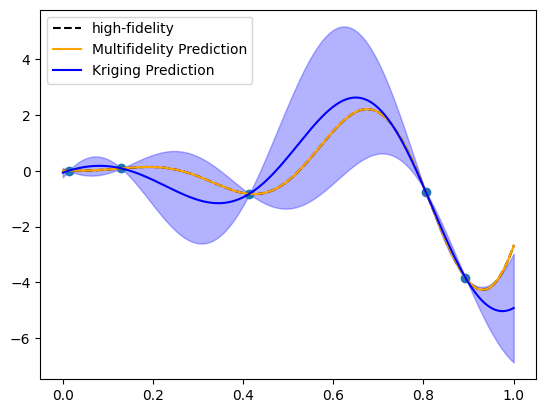

In [138]:
delta_mean, delta_var = g0.predict(X_test.reshape(-1,1), full_cov = False)
lo_mean, lo_var = g1.predict(X_test.reshape(-1,1), full_cov = False)
rho = g0.p['rho']

mean = rho * lo_mean + delta_mean 
var = rho**2 * lo_var + delta_var 
conf = 2 * np.sqrt(var)

kr_mean, kr_var = kr.predict(X_test.reshape(-1,1), full_cov = False)
kr_conf = 2 * np.sqrt(kr_var)

plt.plot(X_test, funcs[0](X_test), label = "high-fidelity", color = 'black', linestyle = 'dashed')
plt.plot(X_test, mean, color = 'orange', label = "Multifidelity Prediction")
plt.fill_between(X_test, mean - conf, mean + conf, alpha = 0.5, color = 'orange')
plt.plot(X_test, kr_mean, color = 'blue', label = "Kriging Prediction")
plt.fill_between(X_test, kr_mean - kr_conf, kr_mean + kr_conf, alpha = 0.3, color = 'blue')
plt.scatter(X_hi, funcs[0](X_hi))
plt.legend()

In [139]:
print("Multifidelity: %.4e" % np.mean(var + (mean - funcs[0](X_test))**2))
print("Kriging:       %.4e" % np.mean(var + (kr_mean - funcs[0](X_test))**2))

Multifidelity: 1.9623e-05
Kriging:       3.7229e-01


In [183]:
def get_mse(key, g0, g1, N_hi, N_lo, X_test):
    # Generating random samples 
    key_hi, key_lo = jax.random.split(key, 2)
    X_hi = jax.random.uniform(key_hi, (N_hi,))
    X_lo = jax.random.uniform(key_lo, (N_lo,))

    # Setting training data 
    g0.X, g0.Y1, g0.Y2 = X_hi.reshape(-1,1), funcs[0](np.array(jax.device_get(X_hi))), funcs[1](np.array(jax.device_get(X_hi)))
    g0.set_params(g0.p)

    g1.X, g1.Y = X_lo.reshape(-1,1), funcs[1](X_lo)
    g1.set_params(g1.p)

    # Making predictions
    delta_mean, delta_var = g0.predict(X_test.reshape(-1,1), full_cov = False)
    lo_mean, lo_var = g1.predict(X_test.reshape(-1,1), full_cov = False)
    rho = g0.p['rho']

    # Computing posterior mean and variance 
    mean = rho * lo_mean + delta_mean 
    var = rho**2 * lo_var + delta_var 

    # Returning Mean squared error of predictions 
    return jnp.mean(var + (mean - funcs[0](X_test))**2)

    

def avg_mse(N_hi, budget, g0, g1, N_mc, C_hi, C_lo, X_test): 
    # Number of low-fidelity samples 
    N_lo = int((budget - N_hi * C_hi) / C_lo)
    print(N_lo)

    key = jax.random.key(42)
    rng_keys = jax.random.split(key, N_mc)

    mses = np.zeros(N_mc)

    for i, key in enumerate(rng_keys):
        mses[i] = get_mse(key, g0, g1, N_hi, N_lo, X_test)

    return jnp.mean(mses)


budget, N_mc = 100, 15

N_hi_min, N_hi_max = 2, int(budget / C_hi)

N_his = jnp.arange(N_hi_min, N_hi_max+1)


results = jnp.array([
    avg_mse(int(N_hi), budget, g0, g1, N_mc, C_hi, C_lo, X_test)
    for N_hi in N_his
])

90
85
80
75
70
65
60
55
50
45
40
35
30
25
20
15
10
5
0


In [184]:
r1 = np.sqrt(C_hi * (1 - corr_coef**2) / (C_hi * (1 - corr_coef**2)))
r2 = np.sqrt(C_hi * corr_coef**2 / (C_lo * (1 - corr_coef**2)))

N_hi_opt = budget / (C_hi + C_lo * np.sqrt(C_hi / C_lo * corr_coef**2 / (1 - corr_coef**2)))
N_lo_opt = N_hi_opt * np.sqrt(C_hi / C_lo * corr_coef**2 / (1 - corr_coef**2))
N_hi_opt, N_lo_opt

(9.287596892973331, 53.56201553513335)

In [190]:
corr_coef = np.sqrt(g0.p['rho']**2 * np.var(funcs[0](X_test)) / np.var(funcs[1](X_test)))

N_hi_opt = budget / (C_hi + C_lo * np.sqrt(C_hi / C_lo * corr_coef**2 / (1 - corr_coef**2)))
N_lo_opt = N_hi_opt * np.sqrt(C_hi / C_lo * corr_coef**2 / (1 - corr_coef**2))
N_hi_opt, N_lo_opt

(18.374530440713247, 8.127347796433764)

In [189]:
corr_coef

Array(0.03765528, dtype=float64)

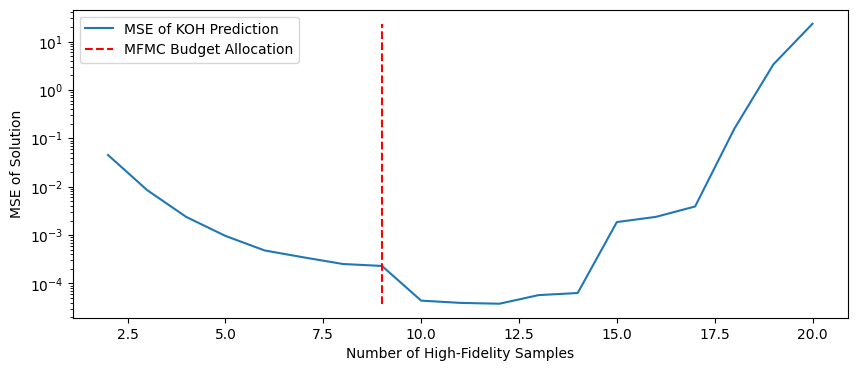

In [185]:
plt.figure(figsize=(10,4))
plt.semilogy(N_his, results, label = "MSE of KOH Prediction")
plt.plot([np.round(N_hi_opt), np.round(N_hi_opt)], [min(results), max(results)], label = "MFMC Budget Allocation", color = 'red', linestyle = 'dashed')
plt.xlabel("Number of High-Fidelity Samples")
plt.ylabel("MSE of Solution")
plt.legend()